In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [2]:
batch_size = 256
learning_rate = 0.0002
num_epoch = 10

In [3]:
mnist_train = dset.MNIST("../", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST("../", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../MNIST/raw/train-images-idx3-ubyte.gz to ../MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../MNIST/raw/train-labels-idx1-ubyte.gz to ../MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../MNIST/raw/t10k-images-idx3-ubyte.gz to ../MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../MNIST/raw/t10k-labels-idx1-ubyte.gz to ../MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
num_class = [0,0,0,0,0,0,0,0,0,0]
for batch_idx,(inputs,target) in enumerate(mnist_train):
  num_class[target] += 1

In [5]:
num_class

[5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]

In [6]:
train_loader = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size, shuffle=False,num_workers=2,drop_last=True)

In [7]:

class Linear(nn.Module):
    def __init__(self):
        super(Linear,self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(784,300),
            nn.ReLU(),
            nn.Linear(300,100),
            nn.ReLU(),
            nn.Linear(100,10),
            nn.ReLU()
        )       
        
    def forward(self,x):
        out = x.view(batch_size,-1)
        out = self.layer(out)

        return out

In [8]:
class CNN(nn.Module):
  def __init__(self):
    # super는 CNN 클래스의 부모 클래스인 nn.Module을 초기화
    super(CNN, self).__init__()
    self.layer = nn.Sequential(
        # 1, 28, 28 -> 16, 28, 28
        nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 5),
        nn.ReLU(),
        # 16, 24, 24 -> 32, 20, 20
        nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 5),
        nn.ReLU(),
        # 32, 20, 20 -> 32, 10, 10
        nn.MaxPool2d(kernel_size = 2, stride = 2),
        # 32, 10, 10 -> 64, 6, 6
        nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 5),
        nn.ReLU(),
        # 64, 3, 3
        nn.MaxPool2d(kernel_size = 2, stride = 2)
    )
    self.fc_layer = nn.Sequential(
        nn.Linear(64 * 3 * 3, 100), # 64 * 3 * 3 -> 100
        nn.ReLU(),
           nn.Linear(100, 10) # 100 -> 10
    )

  def forward(self, x):
    out = self.layer(x) # Sequential 연산 차례대로 실행
    out = out.view(batch_size , -1) # 텐서를 batch_size, 나머지로 바꿔줌

    out = self.fc_layer(out)
    return out

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # GPU 할당

# Colab torch, gpu 확인
print(device)
print("Torch version:{}".format(torch.__version__))
print("cuda version: {}".format(torch.version.cuda))
print("cudnn version:{}".format(torch.backends.cudnn.version()))



cuda:0
Torch version:1.9.0+cu111
cuda version: 11.1
cudnn version:8005


In [10]:
!nvidia-smi

Sun Nov  7 02:56:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    32W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [15]:
model = CNN().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [16]:

loss_arr =[]
for i in range(num_epoch):
    for j,[image,label] in enumerate(train_loader):
        x = image.to(device)
        y_= label.to(device)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()
        
        if j % 1000 == 0:
            print(loss)
            loss_arr.append(loss.cpu().detach().numpy())

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


tensor(2.3012, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2257, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1485, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1771, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0715, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0745, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0470, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0908, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0524, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0414, device='cuda:0', grad_fn=<NllLossBackward>)


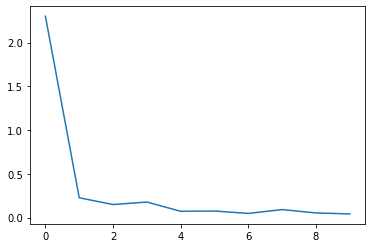

In [17]:

plt.plot(loss_arr)
plt.show()

In [18]:

correct = 0
total = 0

with torch.no_grad():
  for image,label in test_loader:
      x = image.to(device)
      y_= label.to(device)

      output = model.forward(x)
      _,output_index = torch.max(output,1)

      total += label.size(0)
      correct += (output_index == y_).sum().float()

  print("Accuracy of Test Data: {}".format(100*correct/total))

Accuracy of Test Data: 98.64783477783203
